In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
config = '24I/ml_0p01'
# config = '24I/ml_0p005'
# config = '32I/ml0p008'
# config = '32I/ml0p006'
# config = '32I/ml0p004'
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/SD_output.h5'
n_ops = 5

In [3]:
f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
C2pt_tavg = f['pion-00WW'][()]
C3pt_tavg = f['C3pt'][()]    # TODO now these should all be bootstrapped
Cnpt = f['Cnpt'][()]
# R = f['R'][()]
R_boot = f['R'][()]
f.close()
# n_files = Cnpt.shape[0]

In [4]:
# R_boot = bootstrap(R)
R_μ = np.mean(R_boot, axis = 0)
R_σ = np.std(R_boot, axis = 0, ddof = 1)

It looks like David may have found a few regions to fit at each sep: in ml0p004/fits/xml/O1.xml, he is specifying the following regions: 

sep | (tmin, tmax)

15  | (7, 8)

16  | (7, 9)

17  | (7, 10)

18  | (7, 11)

19  | (7, 12)

20  | (7, 13)

...

25  | (7, 18)

So as sep moves up, he increases the maximum fitting range for the data at sep by 1.

TRY TO REPLICATE SOME OF THE PLOTS IN 24I/ml_0p01/fits/results/plots-- see if I can get O1.19 to look the same, and O2.21

Note that I believe these are already jackknifed, i.e. the data in pion_0vbb_4quark_2p.3.1540 for example has already been resampled. This means I shouldn't expect them to match completely, but rather I should expect them to be within statistical error. The second (weight) column also matches up with the resampled uncertainty, as if you evaluate $R_\sigma$ for the corresponding time slice, it compares well to the data in the uncertainty column.

O1.19 matches if I divide my output by 4?
At SEP = 21 (in the filename), so far I've checked that O2, O3, O1p, and O2p match one another. 

TODO why doesn't O1 match up? My O1 that I've saved has to be divided by 4 to match David's graph, although each other operator is fine.

In [5]:
# # Plot C3(t, 2t) / C2(2t)
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, 2 * t]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, 2 * t]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [6]:
# # Plot C3(t, sep) / C2(sep)
# sep = 21
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, sep]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, sep]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [7]:
# Try to replicate the plots in 24I/ml_0p01/plots, this is what is generated by plot_pion_0vbb_4quark_ratios.py
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
# data_slice = np.zeros((n_files, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_μ = np.mean(data_slice, axis = 0)
data_plot_σ = np.std(data_slice, axis = 0, ddof = 1)

<IPython.core.display.Javascript object>


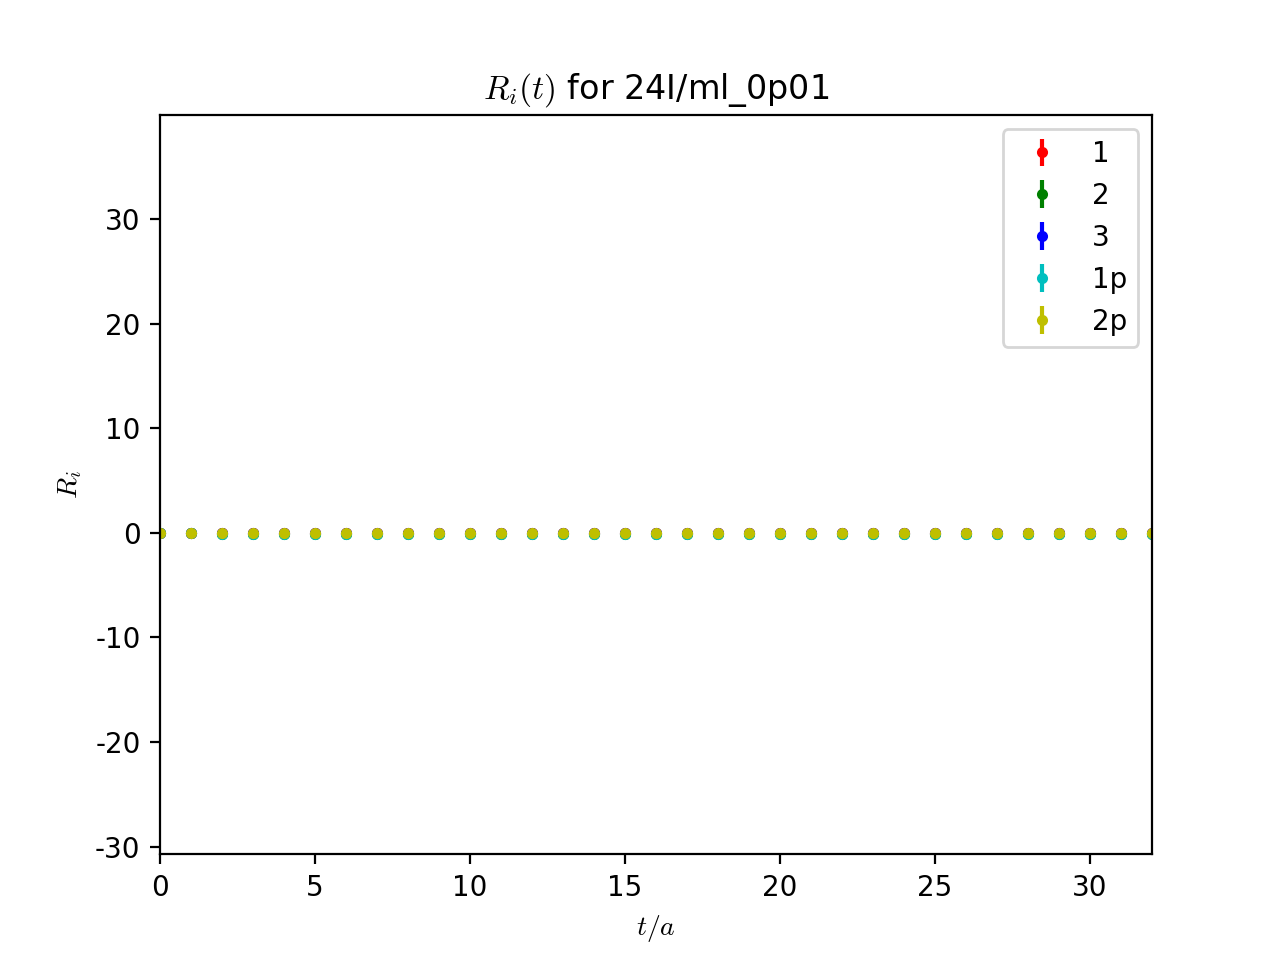

In [8]:
# Plotting R(t, 2t), so need to truncate the graph and data at T // 2
plt.figure()
colors = ['r', 'g', 'b', 'c', 'y']
op_label = ['1', '2', '3', '1p', '2p']
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = op_label[i])
plt.title('$R_i(t)$ for ' + config)
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
# plt.xlim((0, 21.5))
plt.xlim((0, T // 2))
# plt.xlim((0, T))
# plt.ylim((0.00022, 0.00035))
plt.legend()
plt.show()

In [9]:
# plt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/' + config + '/O3_t_2t.pdf'
# plt.savefig(plt_path)

In [10]:
# # fit each linear region to a constant by fitting over a region
# fit_regions = [
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26)
# ]
# fits = np.zeros((n_boot, n_ops), dtype = np.float64)
# for i in range(n_ops):
#     fits[:, i] = fit_constant(fit_regions[i], data_slice[:, i])[0]
# c = np.mean(fits, axis = 0)
# σc = np.std(fits, axis = 0, ddof = 1)

In [11]:
# fits = np.zeros((n_boot, n_ops), dtype = np.float64)
f_acc = []
stats_acc = []
meff_acc = []
weights = []
c = [0, 0, 0, 0, 0]
σc = [0, 0, 0, 0, 0]
for i in range(n_ops):
    results = fit_constant_allrange(data_slice[:, i, : (T // 2)])
    f_acc.append(results[0])
    stats_acc.append(results[1])
    meff_acc.append(results[2])
    weights.append(results[3])
    c[i], σc[i] = analyze_accepted_fits(results[2], results[3])
# c = np.mean(fits, axis = 0)
# σc = np.std(fits, axis = 0, ddof = 1)

Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
196 range(8, 12) 0.01707384961199654 -0.04504023033749523 0.00026581995324922883 241633.02854297298
216 range(9, 13) 0.11893401655387206 -0.04538113309406001 0.0002937024279980727 1378767.41893328
217 range(9, 14) 0.10911135945749473 -0.04545876475807502 0.0002998590309828727 1213488.5991088457
218 range(9, 15) 0.09444273497102952 -0.04552776707625604 0.0003038369650404506 1023027.5671683752
219 range(9, 16) 0.05791422122858387 -0.04560018745092582 0.000307810062327847 611251.0175371716
220 range(9, 17) 0.04658150223117493 -0.0456525241297999 0.00031263107393631167 476594.69648680807
221 range(9, 18) 0.03236484741127024 -0.045707693011558054 0.00031474823399955997 326698.3640576912
222 range(9, 19) 0.01643099102760489 -0.04576348394007637 0.00031846412772419035 162010.33453918318
223 range(9, 20) 0.011752407328620929 -0.04580863103952108 0.00032068481258804726 114279.95225618797
235 range(10, 14) 0.6961425

314 range(14, 31) 0.9971671036937311 -0.04638132516816455 0.00035150867296514926 8070414.719322994
315 range(15, 19) 0.9460437293328775 -0.046232802547791475 0.000354913172835807 7510467.547367663
316 range(15, 20) 0.9780117570450272 -0.04625537429160738 0.0003540715864449395 7801209.157643761
317 range(15, 21) 0.9833372423586292 -0.04628646566329338 0.0003547405605465725 7814132.873599054
318 range(15, 22) 0.9905561287201134 -0.04630697411713552 0.0003575934939895704 7746399.163949903
319 range(15, 23) 0.9960427325025514 -0.046319404351372453 0.0003553855134900263 7886395.073378867
320 range(15, 24) 0.998714101942365 -0.04631969380656985 0.00035512932716777663 7918959.1948657185
321 range(15, 25) 0.9995365997295097 -0.046326995988573774 0.0003536079605784357 7993824.957980205
322 range(15, 26) 0.9996680762501181 -0.046342035981245505 0.000353787172131515 7986778.857772205
323 range(15, 27) 0.9998134406534553 -0.04635323128748231 0.00035475571150096 7944383.088800885
324 range(15, 28) 

400 range(25, 29) 0.9977588554812626 -0.04652787702147001 0.0003772700720262109 7010046.213426882
401 range(25, 30) 0.9994197158688553 -0.04654218398410885 0.00037465538788570755 7120064.823126317
402 range(25, 31) 0.998015565502974 -0.046573192269690346 0.00037458918212495286 7112574.896234758
403 range(26, 30) 0.9968226353017635 -0.04655315831675159 0.00037760713799863587 6990971.000087629
404 range(26, 31) 0.9937553463406332 -0.04658859337216599 0.0003772539460246133 6982515.298206349
405 range(27, 31) 0.9844040103402003 -0.04661179125434534 0.0003774894880255434 6908180.073710838
Number of accepted fits: 180
Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
55 range(2, 6) 0.011304193221541324 -0.07144241685742654 0.0004883673027428065 47396.51542756631
153 range(6, 10) 0.0232058953611179 -0.07568407343267475 0.0006167539315019199 61006.270555165735
175 range(7, 11) 0.10007012930353379 -0.07655709153421299 0.0006426059577185294 242334.34302026298
176 r

290 range(13, 21) 0.9224139703542895 -0.07936231656955095 0.0007619485322143587 1588819.6351652695
291 range(13, 22) 0.9239320531833612 -0.07942793973338405 0.0007656111797500886 1576244.1975886824
292 range(13, 23) 0.9350984664419353 -0.07948257527231814 0.0007632519601070924 1605171.6774301657
293 range(13, 24) 0.9564591828761845 -0.07951289259751335 0.000762250042956368 1646158.0348339248
294 range(13, 25) 0.9646580573909873 -0.07955524047714317 0.0007591412771957168 1673894.8906838053
295 range(13, 26) 0.9631583225033351 -0.07960448502898582 0.0007594042922353456 1670135.0358167437
296 range(13, 27) 0.9646645802497303 -0.07964812213718042 0.0007582131258067461 1678006.875042158
297 range(13, 28) 0.9577445676355613 -0.07969846971748845 0.000756275083382435 1674519.1287264365
298 range(13, 29) 0.9597768639953798 -0.07973661996393103 0.0007548674394005452 1684336.6206264324
299 range(13, 30) 0.9553403054053017 -0.07977978393320619 0.000753202502975286 1683970.936277648
300 range(13, 3

376 range(20, 30) 0.9998856644969539 -0.08014730376912897 0.0007727081815149918 1674631.748935188
377 range(20, 31) 0.9997274006877294 -0.08019668587766614 0.0007685252031174076 1692642.989096171
378 range(21, 25) 0.997903014297397 -0.07995784602866317 0.000780099935497105 1639788.553434012
379 range(21, 26) 0.997894618416651 -0.08001059845671638 0.0007811354350963654 1635430.1566648837
380 range(21, 27) 0.9991907712603495 -0.08004597429936108 0.0007781900421562733 1649973.9050664792
381 range(21, 28) 0.9990139191555766 -0.08009849804275626 0.0007756814207995281 1660369.5519670877
382 range(21, 29) 0.9996021963773908 -0.08012668853018262 0.0007744002722147516 1666848.8040718958
383 range(21, 30) 0.9996807254234702 -0.08016576028290212 0.0007726857012562574 1674385.936006451
384 range(21, 31) 0.9993885066821591 -0.08021797623485542 0.0007684537530987376 1692383.8743656063
385 range(22, 26) 0.9877402989966015 -0.08000625123804013 0.0007751478299280926 1643893.5895628755
386 range(22, 27)

274 range(12, 20) 0.9954336752681437 0.002764094119201066 1.6487678883255625e-05 3661788764.5866995
275 range(12, 21) 0.9982688524169064 0.0027644717386638828 1.642138069802329e-05 3701929823.26787
276 range(12, 22) 0.9991816805622769 0.002764980820940679 1.6504725495540637e-05 3667987539.8193626
277 range(12, 23) 0.9997258373775142 0.002765146085165666 1.6456696531420035e-05 3691438140.387808
278 range(12, 24) 0.9998735740300921 0.00276469579838148 1.6358667516813405e-05 3736364517.6072736
279 range(12, 25) 0.9999604467669098 0.002764779514806088 1.6280275974801283e-05 3772761024.1825223
280 range(12, 26) 0.9999756696172611 0.002765235445187144 1.6349487838102507e-05 3740943320.5590954
281 range(12, 27) 0.999988483210403 0.002765564373251985 1.6431387848764633e-05 3703791276.471139
282 range(12, 28) 0.9999926026386795 0.002765969741719221 1.6473683980969407e-05 3684811926.358226
283 range(12, 29) 0.9999968496421282 0.0027662126243080264 1.653624051348927e-05 3657000933.3501062
284 ran

365 range(19, 27) 0.9996549136971811 0.002766777766285158 1.7335158093809175e-05 3326553340.4998713
366 range(19, 28) 0.9998074629077678 0.0027674328105118497 1.7429422043206246e-05 3291170652.3236146
367 range(19, 29) 0.9999390363852573 0.0027677593313438554 1.7539966871944954e-05 3250244151.4849343
368 range(19, 30) 0.9999645086141956 0.00276835559125701 1.7516683650453803e-05 3258973376.1804323
369 range(19, 31) 0.999978028814664 0.00276891516174284 1.7477623814638653e-05 3273600535.434742
370 range(20, 24) 0.9764495880939766 0.002766001350496501 1.7325042351998984e-05 3253128486.7062273
371 range(20, 25) 0.994992826561252 0.002765955172811625 1.7127407167769306e-05 3391850524.9570193
372 range(20, 26) 0.9974563297331506 0.0027669091739828166 1.7302161944006827e-05 3331909106.5115
373 range(20, 27) 0.9991616406421293 0.002767461552362369 1.7476913569218315e-05 3271193808.2627954
374 range(20, 28) 0.9996019481764268 0.002768136281017979 1.758602502740864e-05 3232151581.305611
375 ran

272 range(12, 18) 0.9437730290336092 -0.14219092389151433 0.0010734336897882228 819062.6439360611
273 range(12, 19) 0.8973903746502202 -0.14235107381248685 0.0010821083709458765 766372.466969127
274 range(12, 20) 0.9068042414186654 -0.14245506020544116 0.0010829533049455202 773203.9798598186
275 range(12, 21) 0.8954013337453124 -0.1425651730625823 0.0010856170298069936 759739.0374417956
276 range(12, 22) 0.9015035800784399 -0.14264672883254015 0.0010924054051392044 755439.6493392149
277 range(12, 23) 0.919655971653916 -0.1427127036446919 0.0010884381055215173 776279.1465664987
278 range(12, 24) 0.946224406042356 -0.14274561291945725 0.0010877102083740554 799774.8382727997
279 range(12, 25) 0.9597087750234914 -0.14279304079365243 0.0010843603946193616 816191.6959173095
280 range(12, 26) 0.961769367715052 -0.14285347952134242 0.001085044009652963 816913.8016022425
281 range(12, 27) 0.9669742075399801 -0.14290209269810467 0.0010871074536755042 818219.7217893805
282 range(12, 28) 0.9632454

359 range(18, 30) 0.9999945239828795 -0.14355573590646117 0.0011322222842045284 780071.1657520278
360 range(18, 31) 0.9999682001915 -0.14361928149935543 0.001132035320965745 780308.3136911464
361 range(19, 23) 0.9963129297787323 -0.14340954494877287 0.00114156917482645 764524.3108899964
362 range(19, 24) 0.9987443117329695 -0.14335663776759477 0.0011399323372874885 768592.5513571589
363 range(19, 25) 0.9998298095062891 -0.14335665490340974 0.0011303332640049298 782551.7447645029
364 range(19, 26) 0.9998889133053014 -0.14340480104035871 0.0011309075254801895 781803.4181762213
365 range(19, 27) 0.9999605753524015 -0.1434373402821892 0.0011346772476655644 776672.9586686678
366 range(19, 28) 0.9999284274248444 -0.14349633496306036 0.0011346446532037916 776692.610782217
367 range(19, 29) 0.9999754068541294 -0.14352253146031468 0.0011382665162574547 771793.9998465042
368 range(19, 30) 0.9999789411997712 -0.14356720708030024 0.001136023274450231 774847.7850199683
369 range(19, 31) 0.999907358

244 range(10, 23) 0.5399109021196404 0.019318960622923268 0.0001827857019234274 16159862.284027936
245 range(10, 24) 0.5684396662211761 0.019329604431992952 0.00018267052873643106 17035206.565287743
246 range(10, 25) 0.5670666860260982 0.01934240575393415 0.000182147407173297 17091813.56972537
247 range(10, 26) 0.5373562811513963 0.01935588868399567 0.00018227546273876468 16173570.68149625
248 range(10, 27) 0.5186228861876456 0.019368299415468006 0.00018208441100328048 15642499.38024482
249 range(10, 28) 0.47316522577677755 0.019381722727557074 0.0001817600274619814 14322408.629501011
250 range(10, 29) 0.46043966207944587 0.019392493834669674 0.0001815221152555143 13973771.557020284
251 range(10, 30) 0.4275907224013686 0.019404169156106023 0.00018124082330736295 13017159.337569915
252 range(10, 31) 0.3654371283470927 0.019417240872820932 0.00018061907532583124 11201738.765604092
253 range(11, 15) 0.9661349267818825 0.019182446131337513 0.0001826597683575636 28956894.0756427
254 range(1

332 range(16, 24) 0.9975440608464291 0.019462070492000286 0.00018851065121499786 28071156.13866942
333 range(16, 25) 0.998927894191136 0.019468709610123577 0.00018735326104886603 28458475.20611923
334 range(16, 26) 0.9990404023108803 0.019478849479527965 0.00018738453135700795 28452182.00248804
335 range(16, 27) 0.9993074269587371 0.01948738643008247 0.00018692709400375477 28599247.50852976
336 range(16, 28) 0.9990958282405337 0.01949825623397283 0.00018643271202721897 28745039.58173849
337 range(16, 29) 0.99933866644785 0.019505712340686304 0.00018609582588502828 28856219.13557848
338 range(16, 30) 0.99928150425387 0.01951481776964482 0.00018569595419607132 28978971.355453894
339 range(16, 31) 0.9986536497974924 0.01952616228367527 0.00018490351415962253 29209529.615640815
340 range(17, 21) 0.9683267331752717 0.019457755424988094 0.00018747666234351733 27550373.791427772
341 range(17, 22) 0.9858173323843162 0.01947044770770755 0.0001895167869839612 27447391.678348448
342 range(17, 23)

In [12]:
# order 1, 2, 3, 1p, 2p
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
print(config)
for i in range(n_ops):
    print(labels[i] + ': ' + str(c[i]) + ' \pm ' + str(σc[i]))

24I/ml_0p01
O1: -0.04629561796216235 \pm 0.0003997422481552316
O2: -0.07966717379958868 \pm 0.0009176876095929674
O3: 0.0027669560600221688 \pm 1.7224604838059174e-05
O1p: -0.14305483895282578 \pm 0.0012542706387783297
O2p: 0.01943832720760978 \pm 0.0002228354358644061


<IPython.core.display.Javascript object>


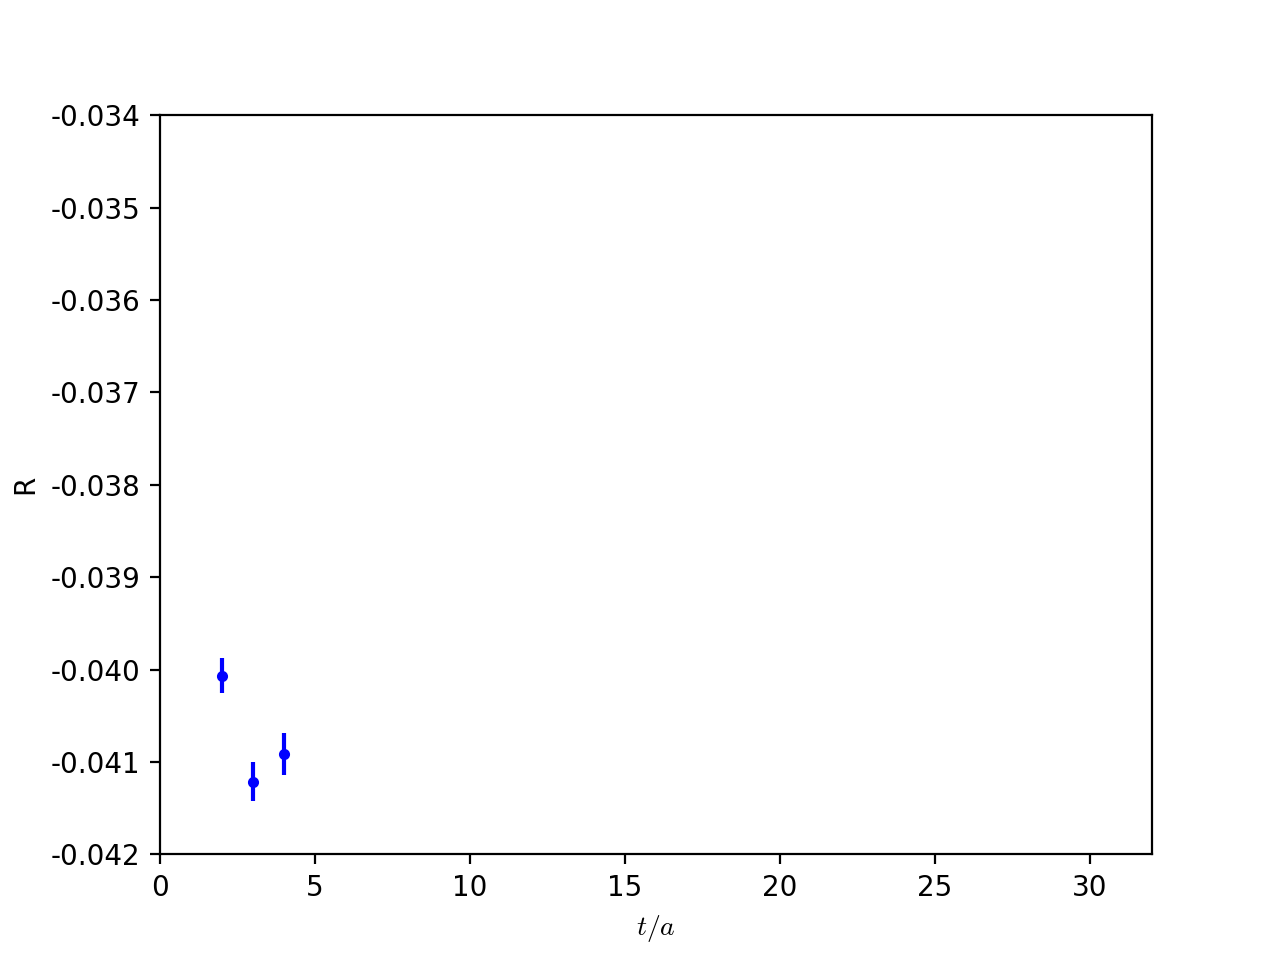

In [13]:
i = 0
plt.figure()
plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = 'b', label = op_label[i])
# plt.fill_between(fit_regions[i], c[i] - σc[i], c[i] + σc[i], color = 'r', alpha = 0.3)
plt.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = 'r', alpha = 0.3)
# plt.title('$\mathcal{O}_2\'$')
plt.xlabel('$t / a$')
plt.ylabel('R')
plt.xlim((0, T // 2))
plt.ylim((-0.042, -0.034))
# plt.ylim((-0.05, -0.038))
# plt.ylim((-0.082, -0.068))
# plt.legend()
plt.show()

In [14]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/grad_student_lunch_club/O1.pdf')

<IPython.core.display.Javascript object>


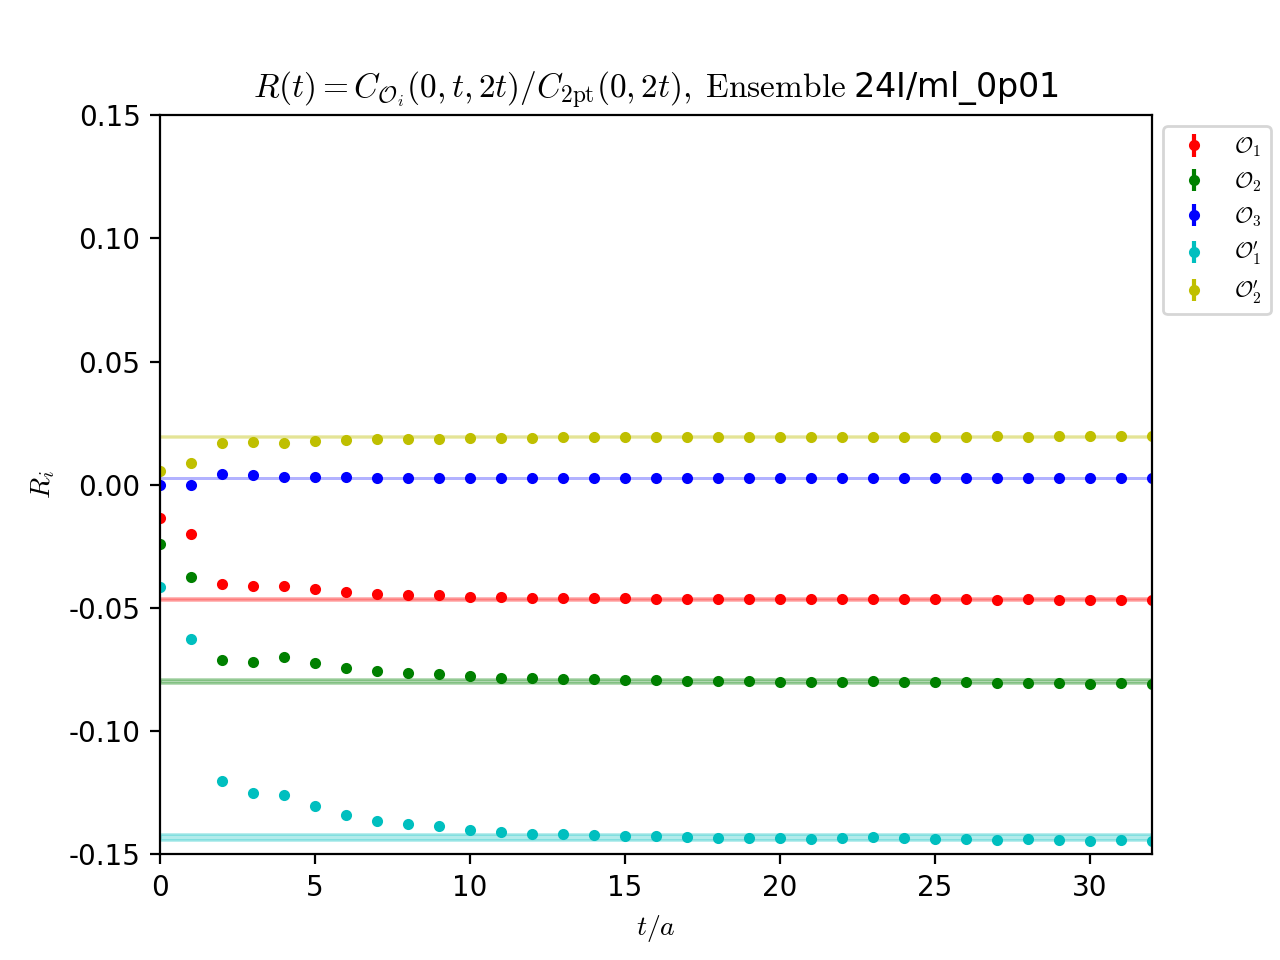

In [15]:
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']
plt.figure()
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    #plt.fill_between(fit_regions[i], c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
    plt.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
plt.title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; \mathrm{Ensemble} \;$' + config)
# plt.title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; \mathrm{Ensemble} \; 24I/a m_{\ell} = 0.01.$')
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
plt.xlim((0, T // 2))
plt.ylim((-0.15, 0.15))
# plt.ylim((-0.042, -0.034))
# plt.ylim((-0.001, 0.025))
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
plt.show()

<IPython.core.display.Javascript object>


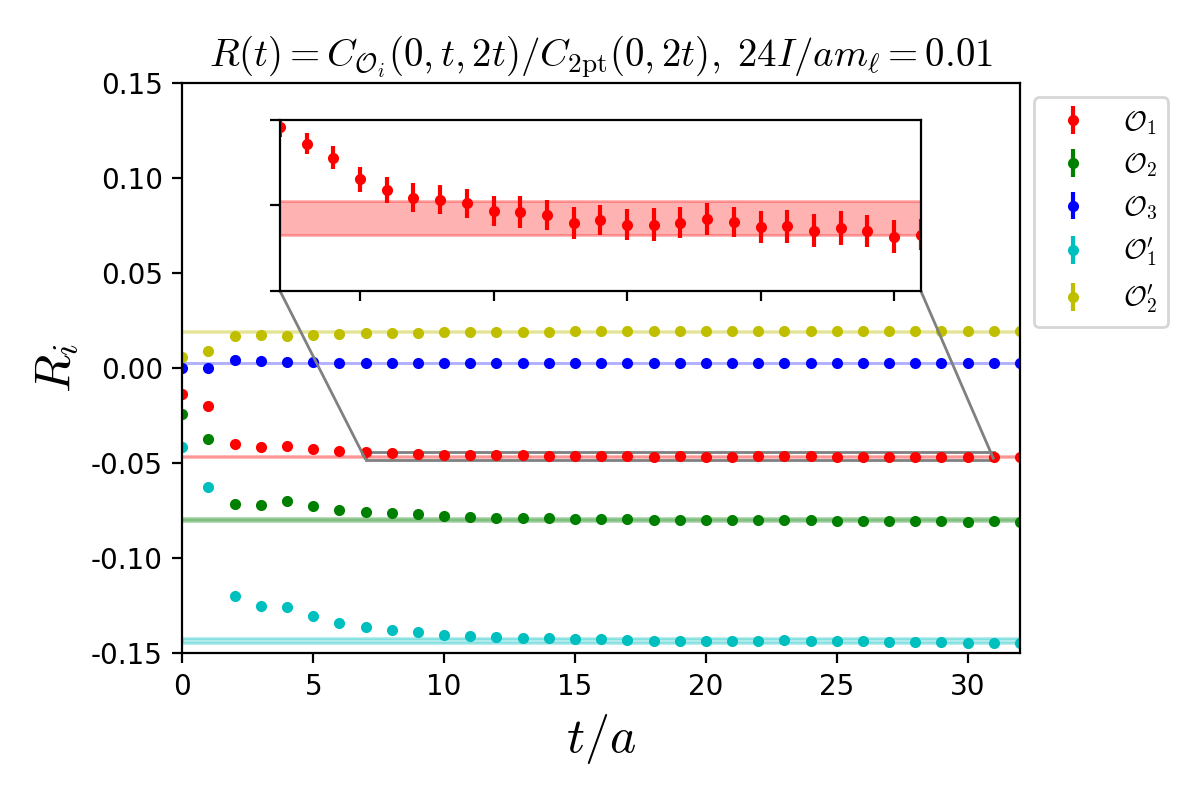

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [16]:
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']

fig, ax = plt.subplots(figsize=[6, 4])

for i in range(n_ops):
    ax.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    ax.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
ax.set_title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; 24I/a m_{\ell} = 0.01.$', fontsize = 14)
ax.set_xlabel('$t / a$', fontsize = 18)
ax.set_ylabel('$R_i$', fontsize = 18)
ax.set_xlim((0, T // 2))
ax.set_ylim((-0.15, 0.15))
# ax.set_xticklabels(Fontsize=16)
# plt.ylim((-0.042, -0.034))
# plt.ylim((-0.001, 0.025))
ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 10})
# plt.show()

# axins = zoomed_inset_axes(ax, 6, loc = 2)
# bbox = Bbox([[5, 0.05], [30, 0.125]])
# bbox = Bbox([[0, 0], [1, 1]])
# axins = zoomed_inset_axes(ax, 1, loc = 2, bbox_to_anchor = (5, 0.05, 20, 0.05))
axins = inset_axes(ax, width="30%", height="30%", loc='upper left',
                   bbox_to_anchor=(0.1, -0.04, 2.55, 1), bbox_transform=ax.transAxes)
for i in range(n_ops):
    axins.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    axins.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
# axins.set_xlim((3, 30))
# axins.set_ylim((-0.048, -0.040))
axins.set_xlim((7, 31))
axins.set_ylim((-0.048, -0.044))
plt.xticks(visible=False)
plt.yticks(visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

plt.draw()
plt.tight_layout()
plt.show()

In [17]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/24I/ml_0p01/poster_figure.pdf')

In [18]:
# fit_plt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/O3_t_2t.pdf'
# plt.savefig(fit_plt_path)

In [19]:
# fit_region_mat = np.array([[t for t in fit_regions[i]] for i in range(n_ops)])
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
# fout = h5py.File(out_file, 'w')
# fout['fits'] = fits
# # fout['fitrange'] = fit_regions
# # fout['fitrange'] = fit_region_mat
# fout.close()

24I/ml0p005
Using fit ranges, here are the results:
O1: -0.03904959592888694 \pm 0.0003288716824284383
O2: -0.0666878741764023 \pm 0.0008544848691336499
O3: 0.001394680973543252 \pm 1.304461961634588e-05
O1p: -0.12236700304358335 \pm 0.0010250036443713053
O2p: 0.016331963334146417 \pm 0.00021078791537872642

24I/ml0p005
Averaging over all fit ranges, this is what we get:
O1: -0.03895617532910957 \pm 0.0003514538198650905
O2: -0.06639419443067024 \pm 0.0009314932148826224
O3: 0.0013964752427535559 \pm 1.3311962233598224e-05
O1p: -0.12208471872628748 \pm 0.0010925713079177164
O2p: 0.016254775174429376 \pm 0.0002400637769421278